<img src="board_photo.jpg" width=250 />

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# start -> end cells for all snakes and ladders
JUMPS = {
    1: 38,
    4: 14,
    9: 31,
    16: 6,
    21: 42,
    28: 84,
    36: 44,
    47: 26,
    49: 11,
    51: 67,
    56: 53,
    62: 19,
    64: 60,
    71: 91,
    80: 100,
    87: 24,
    93: 73,
    95: 75,
    98: 78,
}

FINISH = 100 # Finish cell

In [3]:
def move(start, rolled):
    assert 0 <= start <= FINISH
    if start == FINISH:
        return FINISH # stay on the finish square if already finished
    new = start + rolled
    if new > FINISH:
        new = FINISH - (FINISH - 100) # bounce off the finish square if overrolled
    return JUMPS.get(new, new)


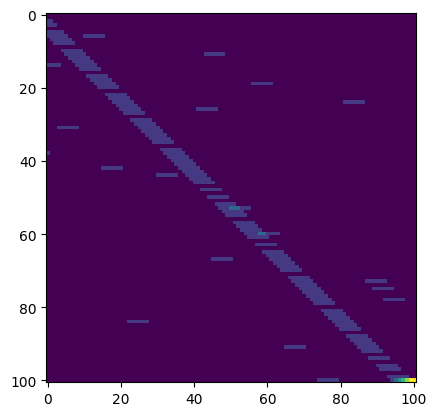

In [4]:
MAX_ROLL = 6 # d6 roll

# move_matrix[new, start] ::= probability to end up in cell `new` in one move from cell `start`
def move_matrix():
    ret = np.zeros((FINISH+1, FINISH+1)) # +1 to accomodate both 0 and FINISH cells
    for start in range(FINISH+1):
        for rolled in range(1, MAX_ROLL+1):
            new = move(start, rolled)
            ret[new,start] += 1/MAX_ROLL
    return ret

MOVE_MATRIX = move_matrix()
plt.imshow(MOVE_MATRIX, interpolation='none', origin='upper')
plt.show()


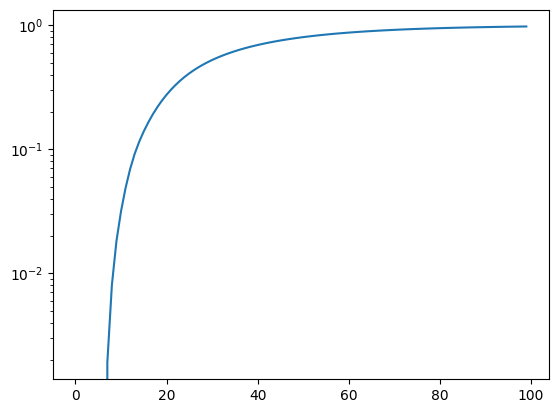

In [5]:
# prob_to_finish[x] ::= probability to finish in `x` moves or less
def prob_to_finish(limit=100):
    current = np.zeros((FINISH+1, 1))
    current[0,0] = 1

    ret = [0]
    for x in range(1, limit):
        current = np.matmul(MOVE_MATRIX, current)
        ret.append(current[-1, 0])
    return ret

PROB_TO_FINISH = prob_to_finish()
plt.semilogy(PROB_TO_FINISH)
plt.show()